# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

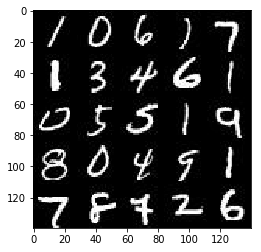

In [5]:
import numpy as np

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

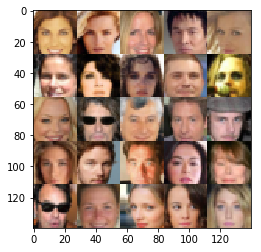

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # img size 28*28*3
        x1 = tf.layers.conv2d(images, 32, 5, strides=1, padding="same")
        relu1 = tf.maximum(0.3*x1, x1)
        
        # img size 28*28*32
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2*bn2, bn2)
        
        # img size 14*14*64
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.3*bn3, bn3)
        
        # img size 7*7*128
        x4 = tf.layers.conv2d(relu3, 256, 5, strides=1, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(0.2*bn4, bn4)                                
        
        # img size 7*7*256
        flattened = tf.reshape(relu4, (-1, 7*7*256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    reuse = not is_train
    alpha = 0.3
    
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse = reuse):
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        # img size is 7*7*512
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # img size is 14*14*256
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # img size is 14*14*128
        x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=2, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        # img size is 28*28*64
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding="same")
        # img size is 28*28*out_channel_dim
        
        output = tf.tanh(logits)
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, is_train=True)
    
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True)    
    
    # discriminator loss
    real_labels = tf.ones_like(d_real_logits)
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=real_labels, logits=d_real_logits))
    
    fake_labels = tf.zeros_like(d_fake_logits)
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=fake_labels, logits=d_fake_logits))
    
    d_loss = real_loss + fake_loss
    
    # generator loss
    g_labels = tf.ones_like(d_fake_logits)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=g_labels, logits=d_fake_logits)) 
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    '''
    # TODO: Implement Function
    ####################################################################################
    ########### why this implementation gets errors in test function ###################
    ####################################################################################
    with tf.trainable_variables(scope="discriminator"):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss)                    
    
    with tf.trainable_variables(scope="generator"):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss)                    
    '''            
    
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in trainable_vars if var.name.startswith("generator")]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)                    
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_images = batch_images * 2
                
                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: z_batch, 
                                                 lr: learning_rate})
                sess.run(g_train_opt, feed_dict={z_input: z_batch, lr: learning_rate})
                
                train_d_loss = d_loss.eval({real_input: batch_images, z_input: z_batch})
                train_g_loss = g_loss.eval({z_input: z_batch})
                
                if(step % 100 == 0):
                    print("Epoch {}/{} ... " .format(epoch_i+1, epoch_count),
                          "Discriminator loss = {:4f}" .format(train_d_loss),
                          "Generator loss = {:4f}" .format(train_g_loss))
                                        
                    
                if(step % 200 == 0):
                    show_generator_output(sess, 25, z_input, data_shape[-1], data_image_mode)
                    
                step += 1    
                
        saver.save(sess, './generator.ckpt')            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5 ...  Discriminator loss = 9.739833 Generator loss = 0.000222


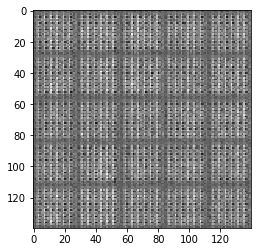

Epoch 1/5 ...  Discriminator loss = 1.751851 Generator loss = 0.254633
Epoch 1/5 ...  Discriminator loss = 1.522076 Generator loss = 0.366655


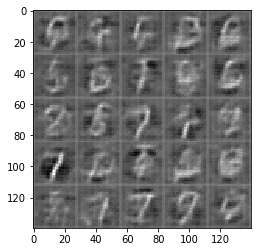

Epoch 1/5 ...  Discriminator loss = 1.664079 Generator loss = 0.300665
Epoch 1/5 ...  Discriminator loss = 1.698642 Generator loss = 0.272918


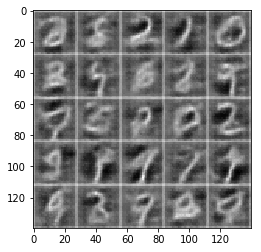

Epoch 2/5 ...  Discriminator loss = 0.990737 Generator loss = 0.728831
Epoch 2/5 ...  Discriminator loss = 1.021677 Generator loss = 0.605893


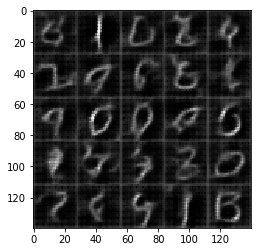

Epoch 2/5 ...  Discriminator loss = 4.165753 Generator loss = 0.036781
Epoch 2/5 ...  Discriminator loss = 1.322169 Generator loss = 2.011605


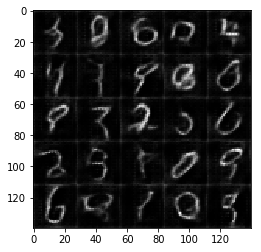

Epoch 2/5 ...  Discriminator loss = 0.431220 Generator loss = 1.599110
Epoch 3/5 ...  Discriminator loss = 0.555757 Generator loss = 1.299027


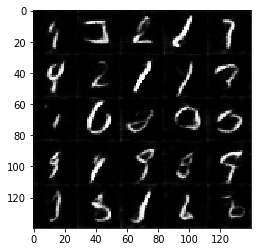

Epoch 3/5 ...  Discriminator loss = 0.218377 Generator loss = 2.440904
Epoch 3/5 ...  Discriminator loss = 0.349754 Generator loss = 2.294029


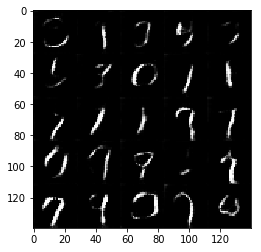

Epoch 3/5 ...  Discriminator loss = 0.558722 Generator loss = 1.539999
Epoch 4/5 ...  Discriminator loss = 2.201954 Generator loss = 0.223555


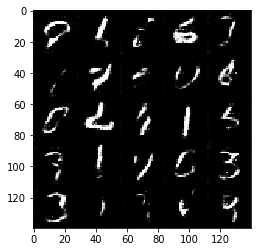

Epoch 4/5 ...  Discriminator loss = 0.406089 Generator loss = 2.189771
Epoch 4/5 ...  Discriminator loss = 0.475264 Generator loss = 1.757496


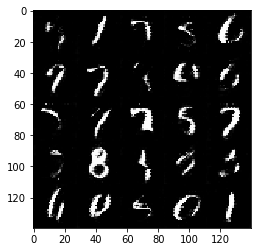

Epoch 4/5 ...  Discriminator loss = 0.366738 Generator loss = 1.914521
Epoch 4/5 ...  Discriminator loss = 1.269617 Generator loss = 0.592279


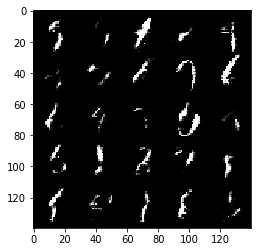

Epoch 5/5 ...  Discriminator loss = 3.198612 Generator loss = 0.242545
Epoch 5/5 ...  Discriminator loss = 0.491511 Generator loss = 1.478173


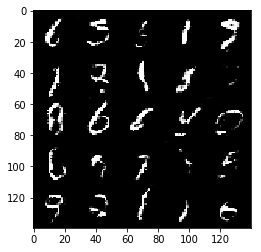

Epoch 5/5 ...  Discriminator loss = 0.595128 Generator loss = 2.580687
Epoch 5/5 ...  Discriminator loss = 0.891683 Generator loss = 2.323456


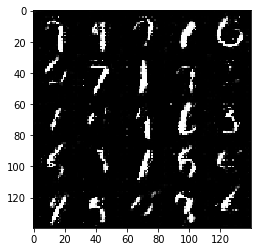

In [28]:
batch_size = 132
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2 ...  Discriminator loss = 19.469818 Generator loss = 0.000000


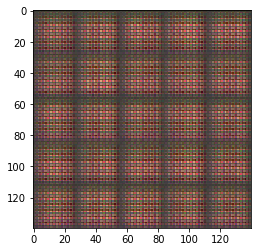

Epoch 1/2 ...  Discriminator loss = 1.288851 Generator loss = 0.783922
Epoch 1/2 ...  Discriminator loss = 0.910571 Generator loss = 1.226635


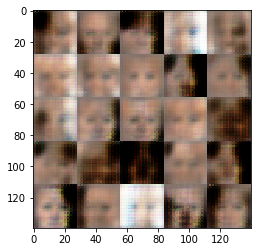

Epoch 1/2 ...  Discriminator loss = 1.254081 Generator loss = 0.856837
Epoch 1/2 ...  Discriminator loss = 1.540600 Generator loss = 0.391597


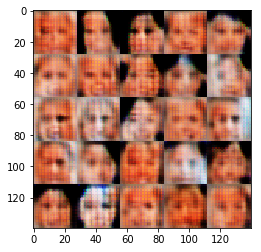

Epoch 1/2 ...  Discriminator loss = 0.701158 Generator loss = 1.501076
Epoch 1/2 ...  Discriminator loss = 0.808450 Generator loss = 1.317302


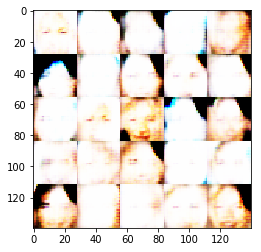

Epoch 1/2 ...  Discriminator loss = 1.477659 Generator loss = 0.406163
Epoch 1/2 ...  Discriminator loss = 1.277650 Generator loss = 1.241794


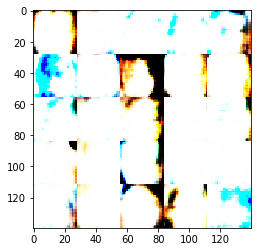

Epoch 1/2 ...  Discriminator loss = 1.502626 Generator loss = 0.602078
Epoch 1/2 ...  Discriminator loss = 1.197044 Generator loss = 0.678036


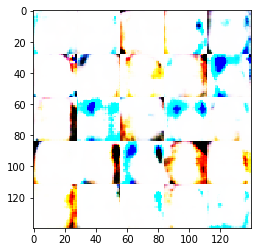

Epoch 1/2 ...  Discriminator loss = 0.023962 Generator loss = 4.265228
Epoch 1/2 ...  Discriminator loss = 2.040384 Generator loss = 0.482826


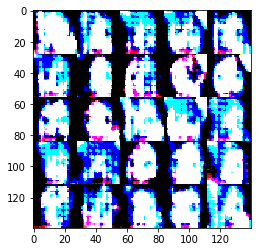

Epoch 1/2 ...  Discriminator loss = 1.116281 Generator loss = 1.006825
Epoch 1/2 ...  Discriminator loss = 1.302627 Generator loss = 1.535455


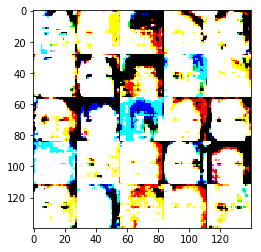

Epoch 1/2 ...  Discriminator loss = 0.874264 Generator loss = 1.289833
Epoch 2/2 ...  Discriminator loss = 0.491396 Generator loss = 4.827898


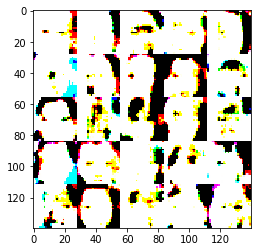

Epoch 2/2 ...  Discriminator loss = 0.809997 Generator loss = 1.381058
Epoch 2/2 ...  Discriminator loss = 1.181286 Generator loss = 0.633915


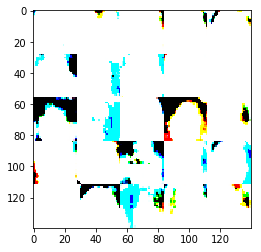

Epoch 2/2 ...  Discriminator loss = 1.022978 Generator loss = 1.297858
Epoch 2/2 ...  Discriminator loss = 0.954579 Generator loss = 1.204067


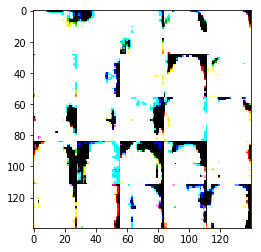

Epoch 2/2 ...  Discriminator loss = 0.053826 Generator loss = 3.778635
Epoch 2/2 ...  Discriminator loss = 1.434651 Generator loss = 0.379236


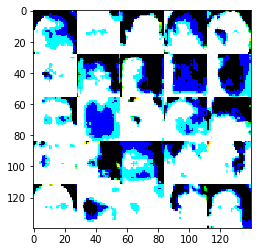

Epoch 2/2 ...  Discriminator loss = 0.929627 Generator loss = 0.973055
Epoch 2/2 ...  Discriminator loss = 0.945500 Generator loss = 0.885472


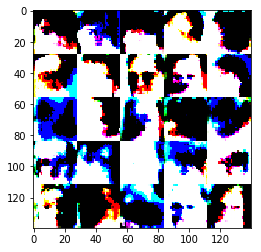

Epoch 2/2 ...  Discriminator loss = 0.118734 Generator loss = 5.019118
Epoch 2/2 ...  Discriminator loss = 1.099679 Generator loss = 0.724370


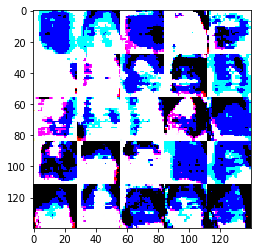

Epoch 2/2 ...  Discriminator loss = 0.395275 Generator loss = 1.435720
Epoch 2/2 ...  Discriminator loss = 1.276547 Generator loss = 0.558418


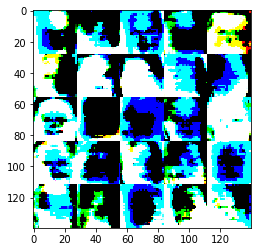

Epoch 2/2 ...  Discriminator loss = 0.048065 Generator loss = 3.887235
Epoch 2/2 ...  Discriminator loss = 0.390655 Generator loss = 2.101600


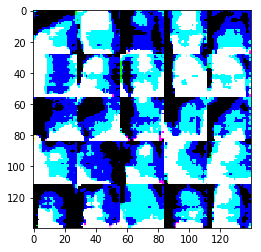

In [32]:
batch_size = 132
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.